### Exercise 1

Dataset shape: (2688, 18078)
Number of spots: 2688
Number of genes: 18078
Available annotations: ['in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster']


<Figure size 1000x1000 with 0 Axes>

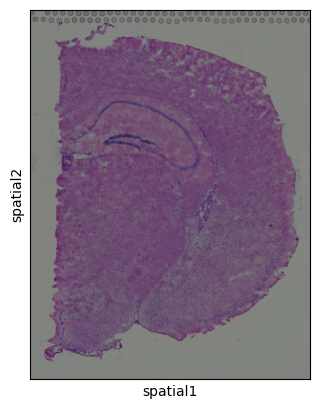

In [4]:
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

adata = sq.datasets.visium_hne_adata()
 
# Basic data exploration
print(f"Dataset shape: {adata.shape}")
print(f"Number of spots: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")
print(f"Available annotations: {list(adata.obs.columns)}")
 
# View tissue image with spots overlaid
plt.figure(figsize=(10, 10))
sc.pl.spatial(adata, img_key="hires", size=1.5)
 
# If annotation is available, visualize with layer annotation
if 'layer_guess' in adata.obs.columns:
    plt.figure(figsize=(10, 10))
    sc.pl.spatial(adata, color='layer_guess', size=1.5)

In [5]:
# Display the first few entries of the gene expression matrix
print("Gene expression matrix (first 5 spots, first 5 genes):")
print(adata.X[0:5, 0:5].toarray())
 
# Display spatial coordinates
print("\nSpatial coordinates (first 5 spots):")
print(adata.obsm['spatial'][0:5])
 
# Check available layers in the AnnData object
print("\nAvailable layers:", list(adata.layers.keys()))
 
# Check available metadata
print("\nSpot metadata:")
print(adata.obs.head())
 
# Check gene metadata
print("\nGene metadata:")
print(adata.var.head())

Gene expression matrix (first 5 spots, first 5 genes):
[[0.         0.         0.87893134 0.87893134 1.3393729 ]
 [0.         0.         1.0922161  1.0922161  1.0922161 ]
 [0.         0.         0.         0.         0.9803591 ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.99697125 0.         0.6179012 ]]

Spatial coordinates (first 5 spots):
[[8230 7237]
 [4170 1611]
 [2519 8315]
 [7679 2927]
 [3138 6280]]

Available layers: []

Spot metadata:
                    in_tissue  array_row  array_col  n_genes_by_counts  \
AAACAAGTATCTCCCA-1          1         50        102               4928   
AAACAATCTACTAGCA-1          1          3         43               3448   
AAACACCAATAACTGC-1          1         59         19               6022   
AAACAGAGCGACTCCT-1          1         14         94               4311   
AAACCGGGTAGGTACC-1          1         42         28               5787   

                    log1p_n_genes_by_counts  total_counts  log1p_to

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


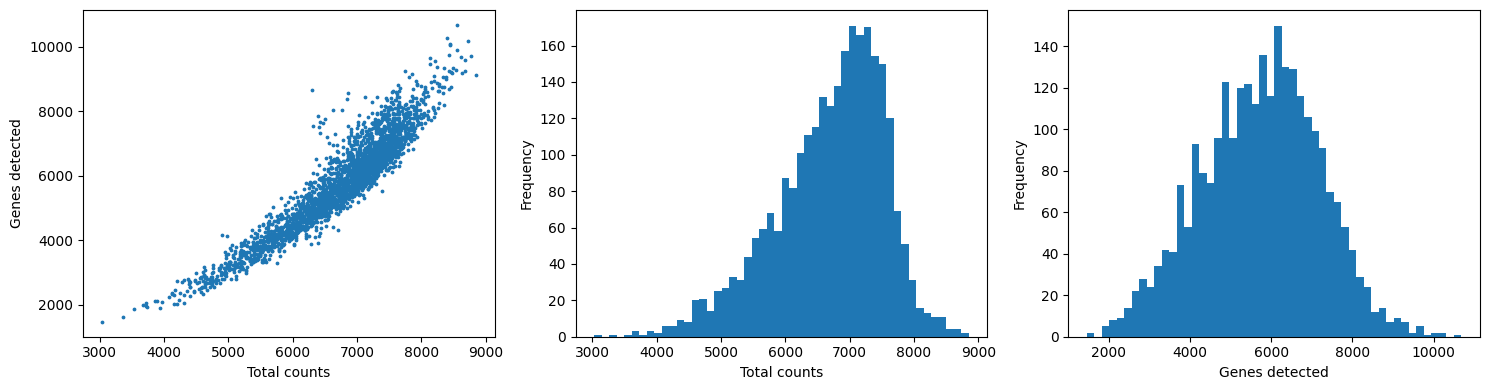

Number of highly variable genes: 2000


<Figure size 800x600 with 0 Axes>

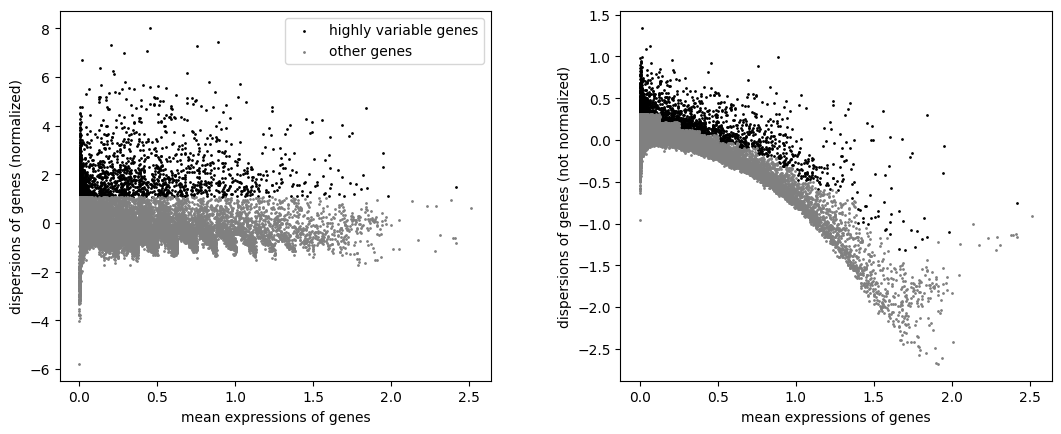

Filtered data shape: (2688, 2000)


/Users/mnozkiewicz/Magisterka/Wizualizacja/venv/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


<Figure size 1000x800 with 0 Axes>

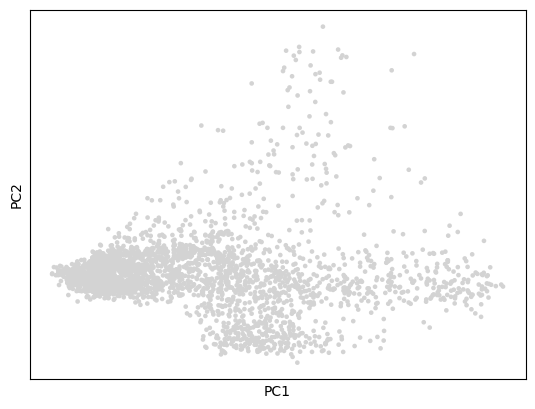

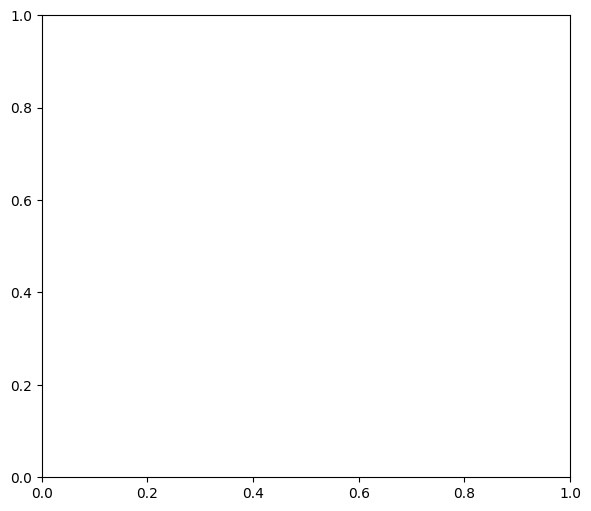

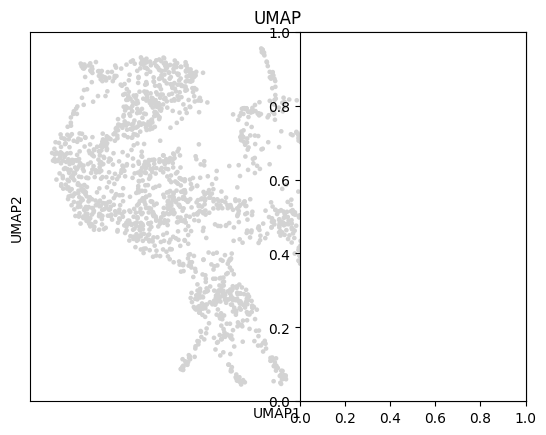

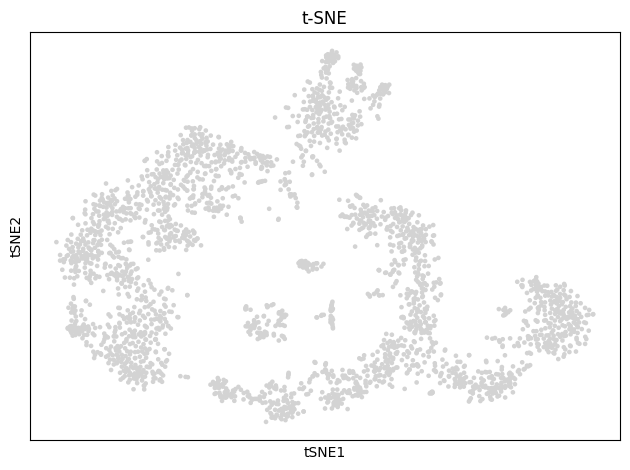

Number of clusters: 20


In [6]:
# Quality control
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
 
# Visualize QC metrics
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.scatter(adata.obs.total_counts, adata.obs.n_genes_by_counts, s=3)
plt.xlabel('Total counts')
plt.ylabel('Genes detected')
plt.subplot(1, 3, 2)
plt.hist(adata.obs.total_counts, bins=50)
plt.xlabel('Total counts')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(adata.obs.n_genes_by_counts, bins=50)
plt.xlabel('Genes detected')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
 
# Filter out spots with low quality if needed
# sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)
 
# Normalize data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
 
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
print(f"Number of highly variable genes: {sum(adata.var.highly_variable)}")
 
# Plot variable genes
plt.figure(figsize=(8, 6))
sc.pl.highly_variable_genes(adata)
 
# Filter to highly variable genes
adata_hvg = adata[:, adata.var.highly_variable]
print(f"Filtered data shape: {adata_hvg.shape}")
 
# Scale data
sc.pp.scale(adata_hvg)
 
# Compute PCA
sc.tl.pca(adata_hvg, svd_solver='arpack')
 
# Visualize PCA
plt.figure(figsize=(10, 8))
sc.pl.pca(adata_hvg, color='layer_guess' if 'layer_guess' in adata.obs.columns else None)
 
# Compute neighborhood graph
sc.pp.neighbors(adata_hvg, n_neighbors=10, n_pcs=30)
 
# Run UMAP and t-SNE
sc.tl.umap(adata_hvg)
sc.tl.tsne(adata_hvg)
 
# Visualize embeddings
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sc.pl.umap(adata_hvg, color='layer_guess' if 'layer_guess' in adata.obs.columns else None, show=False)
plt.title("UMAP")
plt.subplot(1, 2, 2)
sc.pl.tsne(adata_hvg, color='layer_guess' if 'layer_guess' in adata.obs.columns else None, show=False)
plt.title("t-SNE")
plt.tight_layout()
plt.show()
 
# Prepare data for neural network
X = adata_hvg.X.copy()  # Use highly variable genes
 
# If layer_guess is available, prepare class labels
if 'layer_guess' in adata.obs.columns:
    layer_categories = adata.obs['layer_guess'].cat.categories
    y = adata.obs['layer_guess'].cat.codes.values
    print(f"Number of layers/classes: {len(layer_categories)}")
    print(f"Layer categories: {layer_categories}")
else:
    # If no annotations, we can use clustering
    sc.tl.leiden(adata_hvg)
    y = adata_hvg.obs['leiden'].astype('category').cat.codes.values
    print(f"Number of clusters: {len(np.unique(y))}")

In [7]:
from numpy import indices
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch

class NetworkDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

y = y.astype(np.int64)
indices = np.arange(len(y))

X_train, X_temp, y_train, y_temp, train_ind, temp_ind = train_test_split(X, y, indices, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test, val_ind, test_ind = train_test_split(X_temp, y_temp, temp_ind, test_size=0.5, random_state=42)

train_loader = DataLoader(NetworkDataset(X_train, y_train), batch_size=64)
val_loader = DataLoader(NetworkDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(NetworkDataset(X_test, y_test), batch_size=64)

In [8]:
from collections import OrderedDict
import torch.nn as nn

class Network(nn.Module):

    def __init__(self, dropout: float = 0.5):
        super().__init__()

        self.dropout = dropout
        self.model = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(2000, 256)),
            ('relu1', nn.ReLU()),
            ('dropout1', nn.Dropout(0.5)),
            ('linear2', nn.Linear(256, 64)),
            ('relu2', nn.ReLU()),
            ('dropout2', nn.Dropout(0.5)),
            ('linear3', nn.Linear(64, 20)),
        ]))
 
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    @torch.no_grad
    def retrieve_hidden_states(self, x, target_name: str) -> torch.Tensor:
        self.eval()
        if target_name == "input_layer":
            return x
        for layer_name, layer in self.model.named_children():
            x = layer(x)
            if layer_name == target_name:
                return x
        
        raise ValueError(f"Model does not have a layer named: {layer_name}")


In [10]:
import torch.optim as optim
from copy import deepcopy
from typing import Callable


def evaluate_model(
        model: nn.Module,
        loader: DataLoader,
        loss_fn: Callable
    ) -> tuple[float, float]:

    total_loss = 0.0
    correct = 0
    total_images = 0
    number_of_batches = 0

    model = model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images, labels
            outputs = model(images)
            
            batch_loss = loss_fn(outputs, labels)
            total_loss += batch_loss.item()

            correct += (outputs.argmax(axis=1) == labels).sum()
            total_images += outputs.shape[0]

            number_of_batches += 1

    average_loss = total_loss / number_of_batches
    accuracy = correct / total_images

    return average_loss, accuracy


def plot_training_stats(train_loss: list[float], val_loss: list[float]) -> None:
    epochs = len(train_loss)
    plt.xticks(range(0, epochs, 3))

    plt.plot(train_loss, color='red', label="Training loss")
    plt.plot(val_loss, color='blue', label="Validation loss")

    plt.xlabel("Epoch number")
    plt.ylabel("Average batch loss")

    plt.legend()
    plt.show()
    

def train_model(
        model: Network, 
        train_loader: DataLoader, 
        val_loader: DataLoader,
    ) -> Network:

    optimizer = optim.AdamW(model.parameters())
    criterion = nn.CrossEntropyLoss()

    best_model, best_loss = model, float("inf")
    steps_without_improvement = 0
    train_losses, val_losses = [], []

    for epoch in range(20):
        epoch_loss = 0.0
        number_of_batches = 0
        model.train()

        for inputs, labels in train_loader:
            inputs, labels = inputs, labels
            
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            batch_loss.backward()

            optimizer.step()
            optimizer.zero_grad()
        
            epoch_loss += batch_loss.item()
            number_of_batches += 1
        
        train_loss = epoch_loss / number_of_batches
        train_losses.append(train_loss)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)

        if epoch % 4 == 0:
            print(f"Epoch {epoch}")
            print(f"Train average loss: {train_loss:.3f}, Validation average loss: {val_loss:.3f}")
            print(f"Validation accuracy: {100*val_accuracy:.2f}%\n")

        if val_loss < best_loss:
            steps_without_improvement = 0
            best_loss = val_loss
            best_model = deepcopy(model)
        else:
            steps_without_improvement += 1
            if steps_without_improvement > 2:
                print("Early stopping")
                print(f"Epoch {epoch}")
                print(f"Train average loss: {train_loss:.3f}, Validation average loss: {val_loss:.3f}")
                print(f"Validation accuracy: {100*val_accuracy:.2f}%\n")
                break 
    
    plot_training_stats(train_losses, val_losses)
    return best_model

Epoch 0
Train average loss: 2.245, Validation average loss: 1.251
Validation accuracy: 67.47%

Epoch 4
Train average loss: 0.282, Validation average loss: 0.274
Validation accuracy: 91.45%

Epoch 8
Train average loss: 0.102, Validation average loss: 0.269
Validation accuracy: 91.82%

Early stopping
Epoch 10
Train average loss: 0.071, Validation average loss: 0.255
Validation accuracy: 92.01%



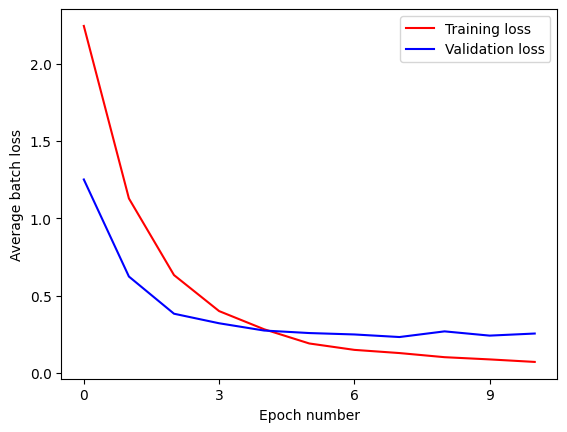

In [11]:
net = Network()
net = train_model(net, train_loader, val_loader)

In [12]:
def retrieve_layer_outputs(model: Network, loader: DataLoader, layer_name: str) -> tuple[torch.Tensor, torch.Tensor]:
    all_hidden_states = []
    all_labels = []

    for batch, labels in loader:
        batch_hidden_states = model.retrieve_hidden_states(batch, layer_name)
        all_hidden_states.append(batch_hidden_states)
        all_labels.append(labels)

    return torch.concat(all_hidden_states), torch.concat(all_labels)

In [13]:
train_input, train_labels = retrieve_layer_outputs(net, train_loader, "input_layer")
test_input, test_labels = retrieve_layer_outputs(net, test_loader, "input_layer")

train_hidden1, _ = retrieve_layer_outputs(net, train_loader, "linear1")
test_hidden1, _  = retrieve_layer_outputs(net, test_loader, "linear1")

train_hidden2, _ = retrieve_layer_outputs(net, train_loader, "linear2")
test_hidden2, _  = retrieve_layer_outputs(net, test_loader, "linear2")

train_hidden3, _ = retrieve_layer_outputs(net, train_loader, "linear3")
test_hidden3, _  = retrieve_layer_outputs(net, test_loader, "linear3")

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from trimap import TRIMAP
from pacmap import PaCMAP
from sklearn.neighbors import KNeighborsClassifier

def get_embedding_class(algorithm: str, **alg_kw):
    match algorithm:
        case "tsne":
            embedding = TSNE(n_components=2, **alg_kw)
        case "umap":
            embedding = UMAP(n_components=2, **alg_kw)
        case "trimap":
            embedding = TRIMAP(n_dims=2, **alg_kw)
        case "pacmap":
            embedding = PaCMAP(n_components=2, **alg_kw)
        case _:
            embedding = PCA(n_components=2)

    return embedding


def train_knn(data_points: np.ndarray, labels: np.ndarray, n_neihgbors: int):
    knn = KNeighborsClassifier(n_neighbors=n_neihgbors)
    knn.fit(data_points, labels)
    return knn

def plot_spatial_embedding(embedding, title, labels, spatial_coords):
    plt.figure(figsize=(15, 6))
 
    # Display the embedding
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                          c=labels, cmap='tab10', s=5)
    plt.title(f'{title} Embedding')
    plt.colorbar(scatter)
 
    # Display the same points in their spatial locations
    plt.subplot(1, 2, 2)
    plt.scatter(spatial_coords[:, 0], spatial_coords[:, 1],
                c=labels, cmap='tab10', s=5)
    plt.title(f'Spatial Organization')
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()


def plot_and_evaluate_embedding(
    train_data: np.ndarray,
    train_labels: np.ndarray,
    train_spatial_coords: np.ndarray,
    test_data: np.ndarray,
    test_labels: np.ndarray,
    test_spatial_coords: np.ndarray,
    embedding_algorithm: str,
    n_neighbors_list: list[int]
) -> None:
    
    embedding_algo = get_embedding_class(algorithm=embedding_algorithm)
    train_embedded = embedding_algo.fit_transform(train_data)
    plot_spatial_embedding(train_embedded, embedding_algorithm, train_labels, train_spatial_coords)
    

    if embedding_algorithm != "umap":
        return
    
    test_embedded = embedding_algo.transform(test_data)
    
    for n_neighbors in n_neighbors_list:
        print(f"KNN with {n_neighbors} nearest neighbors")
        knn = train_knn(train_embedded, train_labels, n_neighbors)
        test_classified = knn.predict(test_embedded)

        accuracy = (test_classified == test_labels).sum() / test_labels.shape[0]
        print(f"Accuracy: {100*accuracy:.2f}%\n")


train_spatial_coords = adata.obsm['spatial'][train_ind]  # Assuming you've tracked indices
val_spatial_coords = adata.obsm['spatial'][val_ind]  # Assuming you've tracked indices
test_spatial_coords = adata.obsm['spatial'][test_ind]  # Assuming you've tracked indices

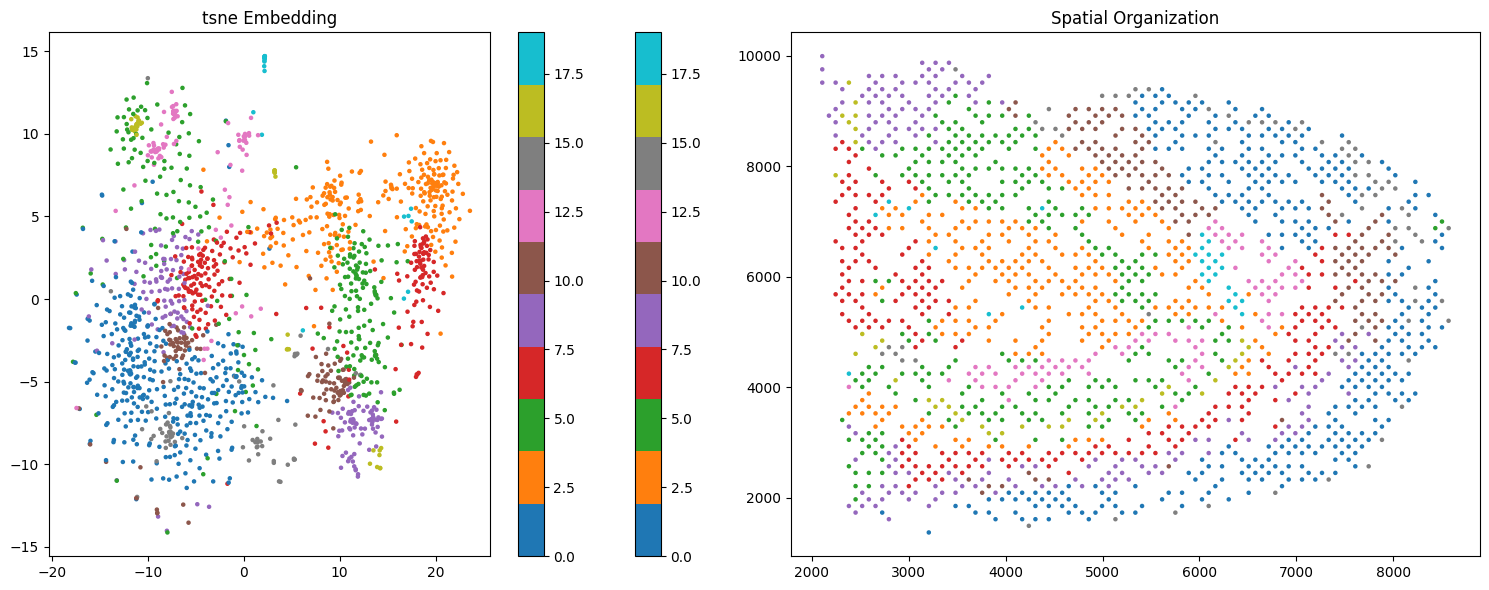

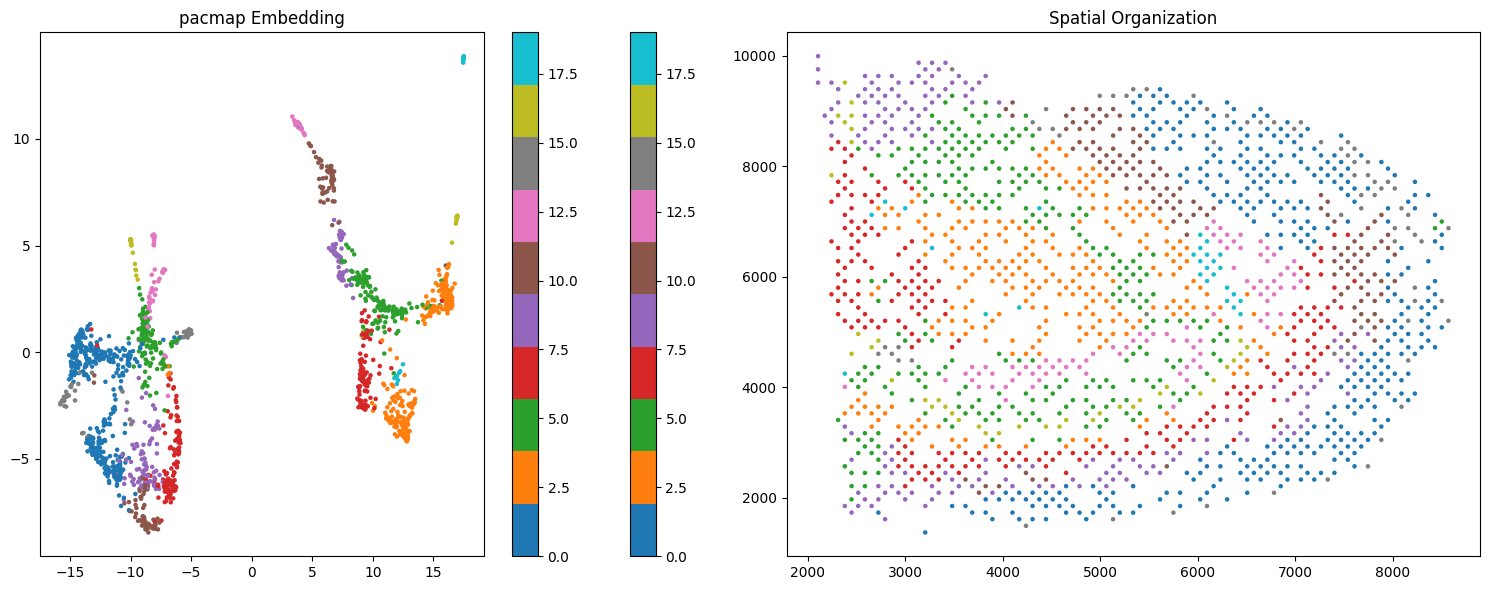

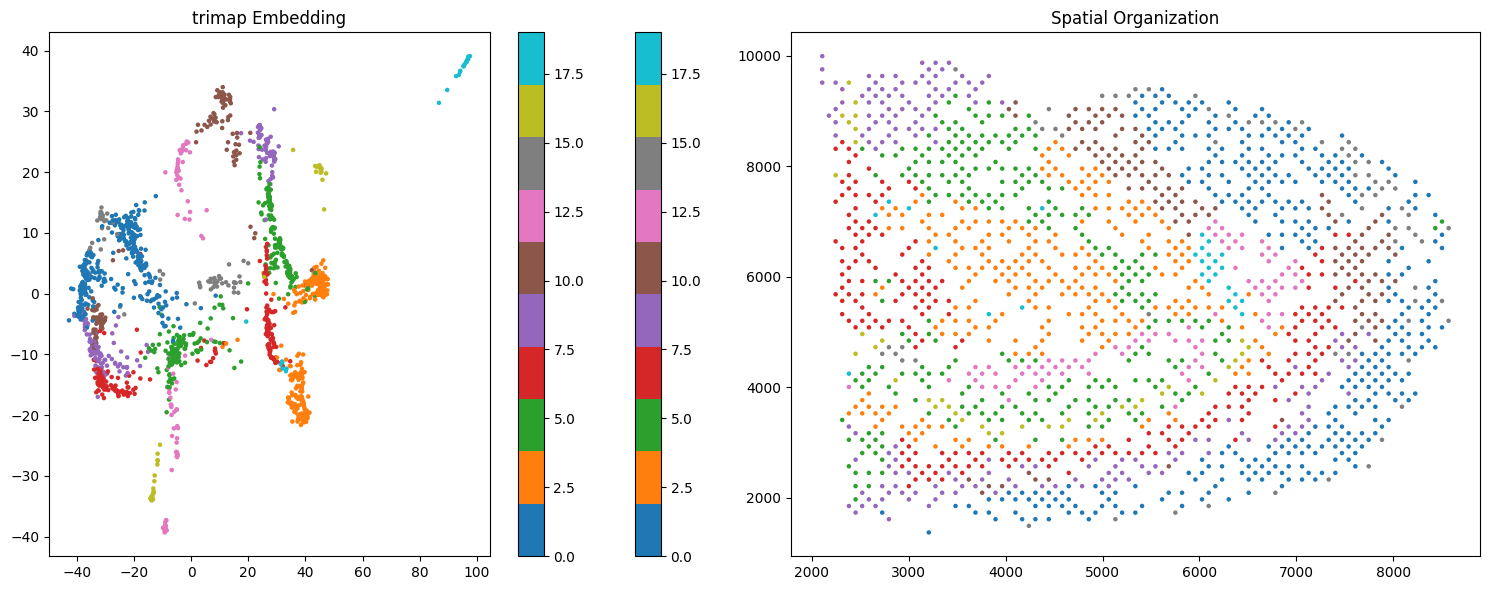

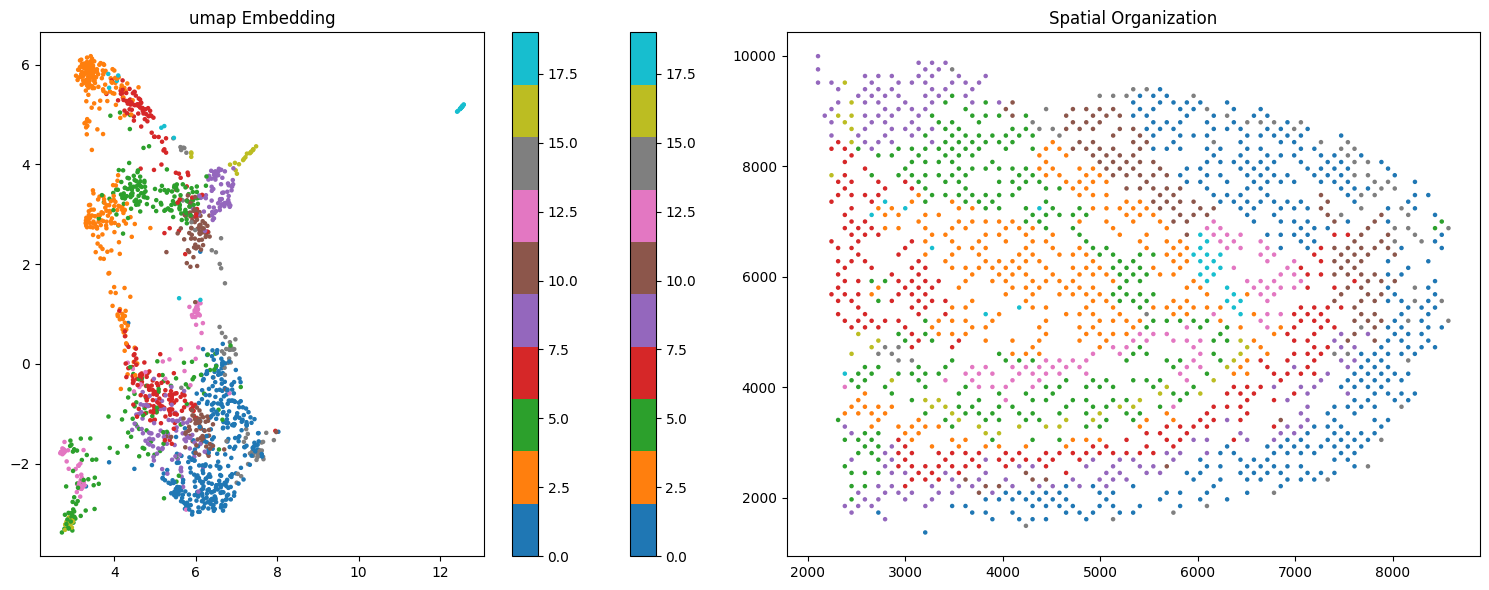

KNN with 3 nearest neighbors
Accuracy: 68.77%

KNN with 5 nearest neighbors
Accuracy: 68.77%

KNN with 10 nearest neighbors
Accuracy: 68.59%



In [15]:
embeddings_algorithms = ["tsne", "pacmap", "trimap", "umap"]

for embedding_algorithm in embeddings_algorithms:
    plot_and_evaluate_embedding(
        train_input.numpy(), 
        train_labels.numpy(), 
        train_spatial_coords,
        test_input.numpy(), 
        test_labels.numpy(),
        test_spatial_coords,
        embedding_algorithm,
        [3, 5, 10]
    )

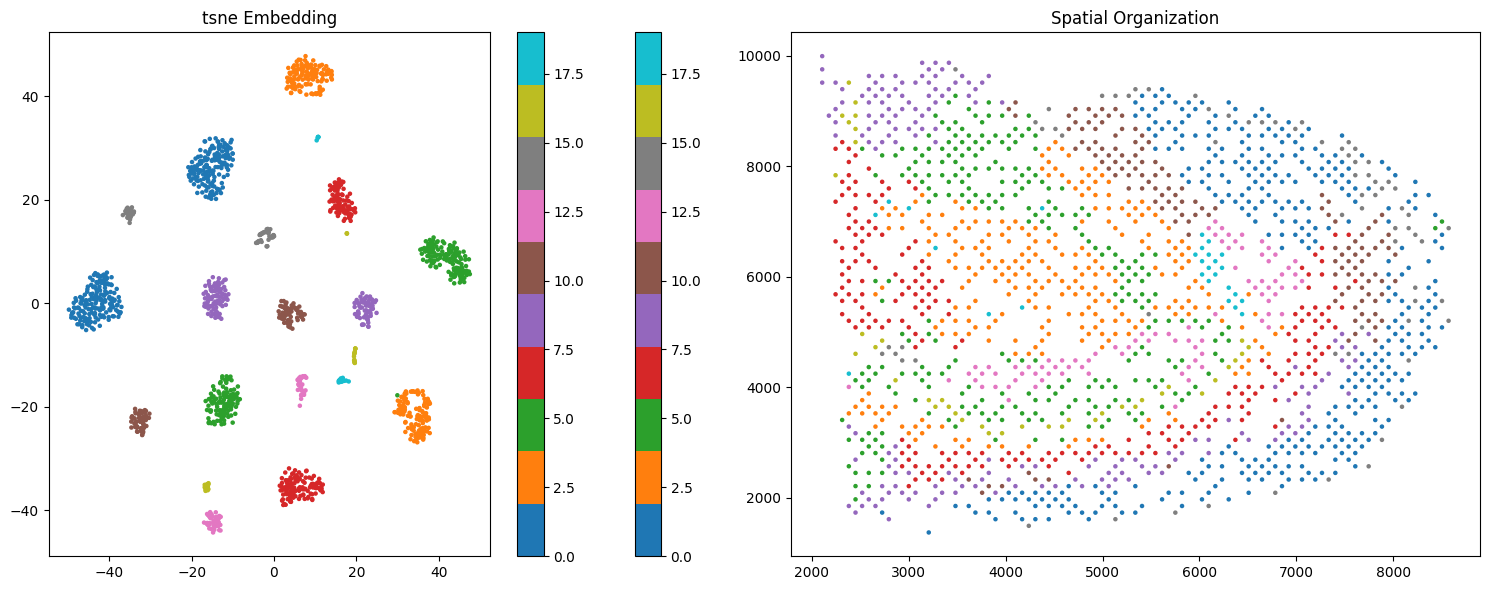

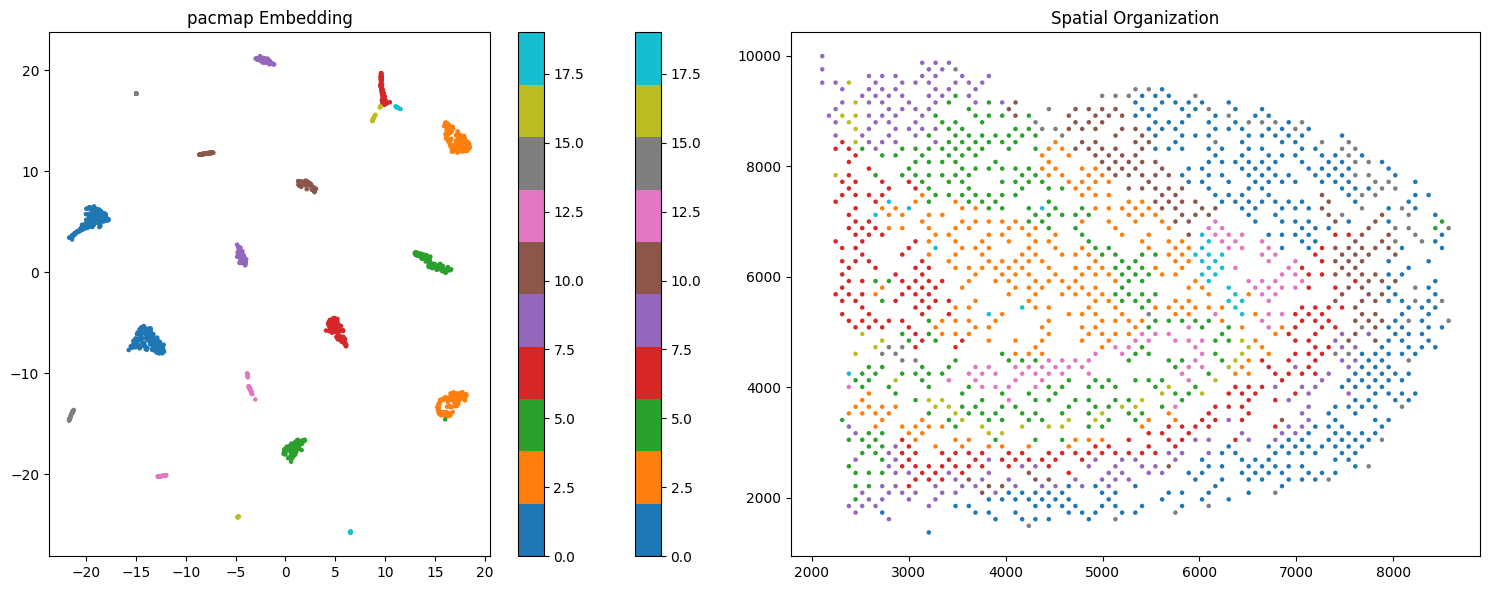

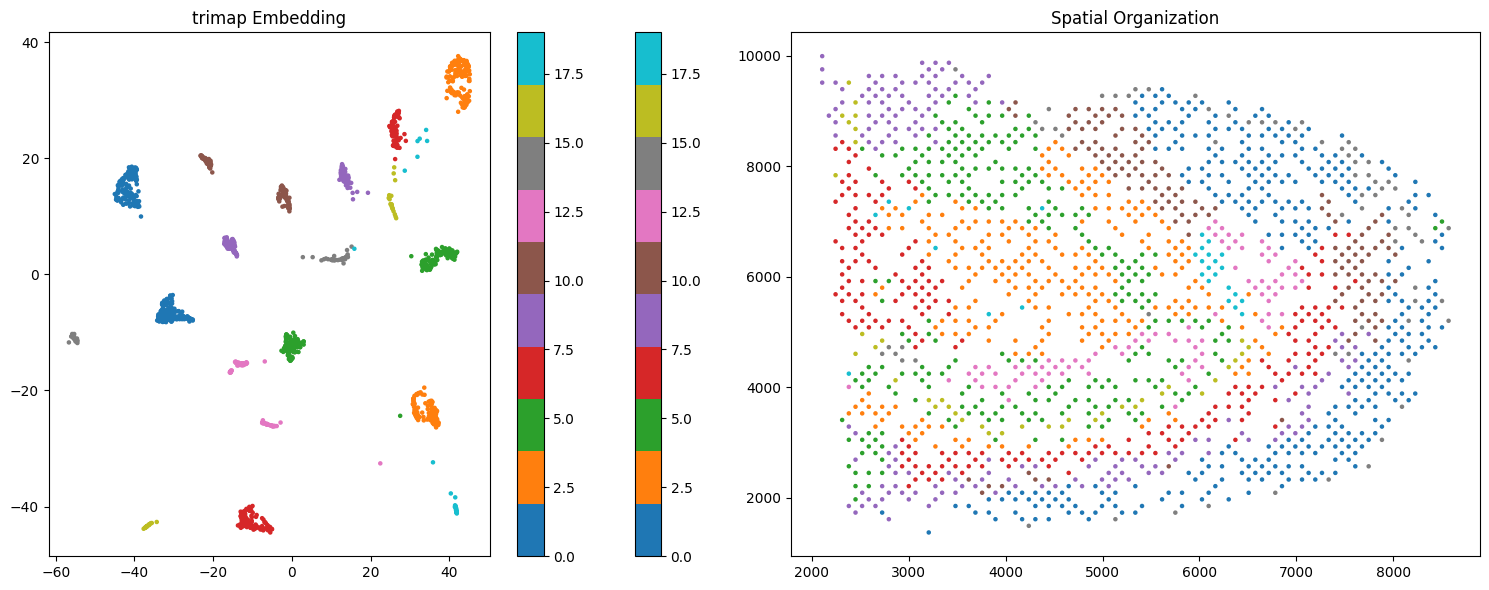

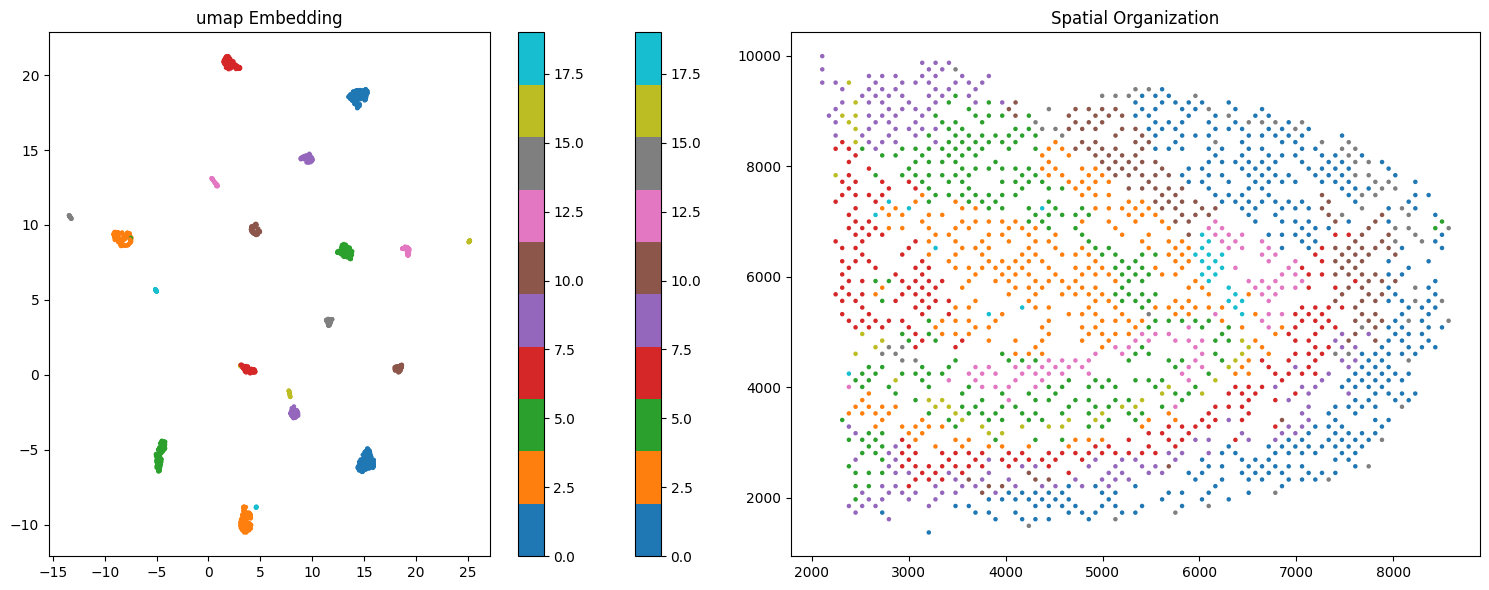

KNN with 3 nearest neighbors
Accuracy: 89.96%

KNN with 5 nearest neighbors
Accuracy: 90.15%

KNN with 10 nearest neighbors
Accuracy: 90.15%



In [16]:
for embedding_algorithm in embeddings_algorithms:
    plot_and_evaluate_embedding(
        train_hidden1.numpy(), 
        train_labels.numpy(), 
        train_spatial_coords,
        test_hidden1.numpy(), 
        test_labels.numpy(), 
        test_spatial_coords,
        embedding_algorithm,
        [3, 5, 10]
    )

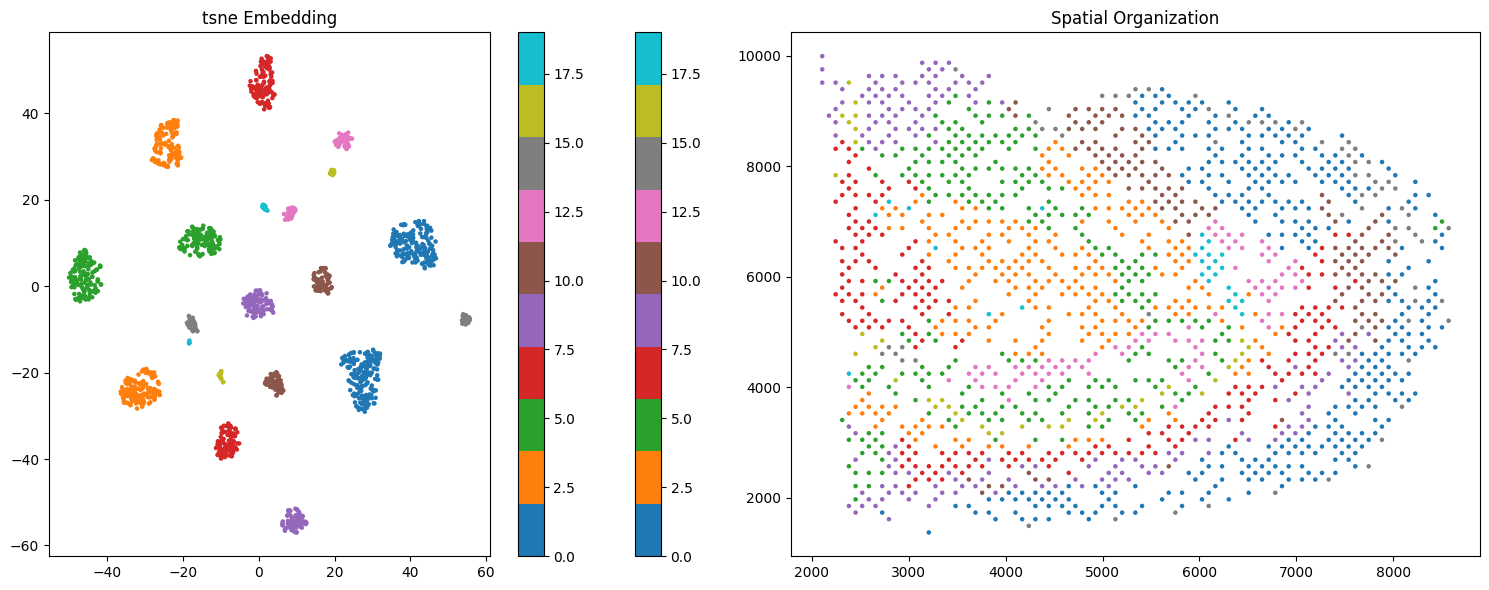

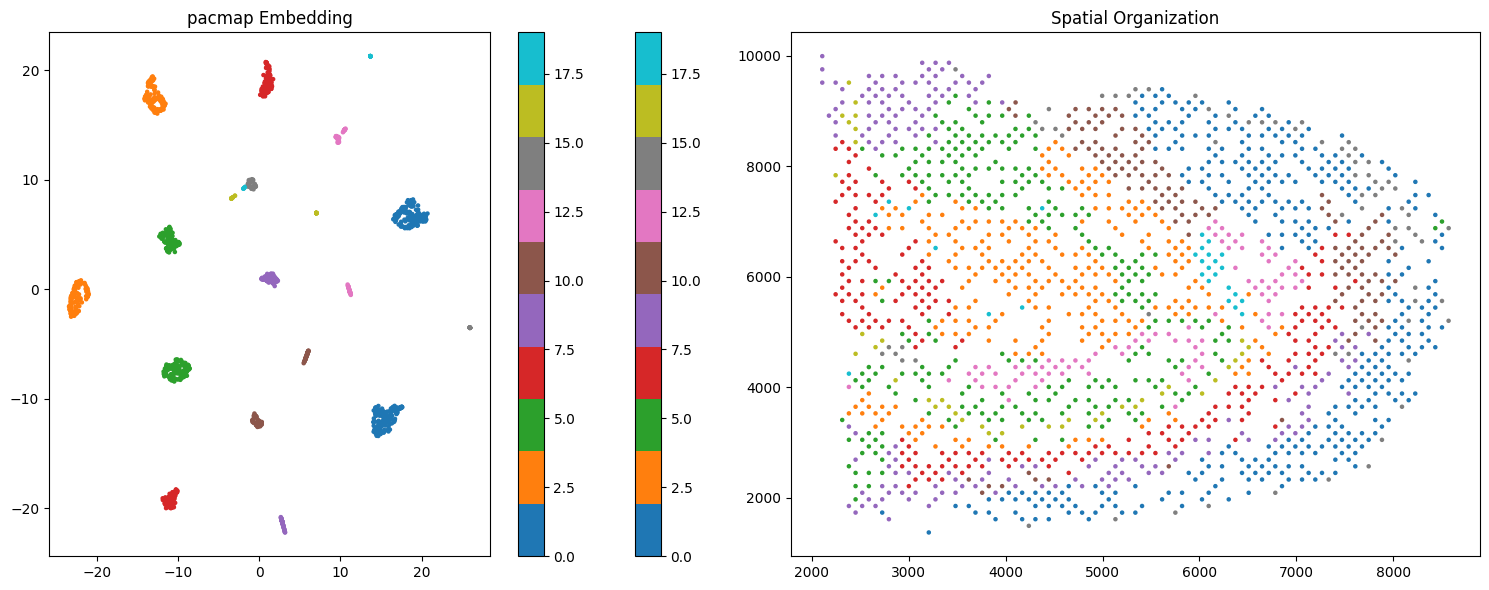

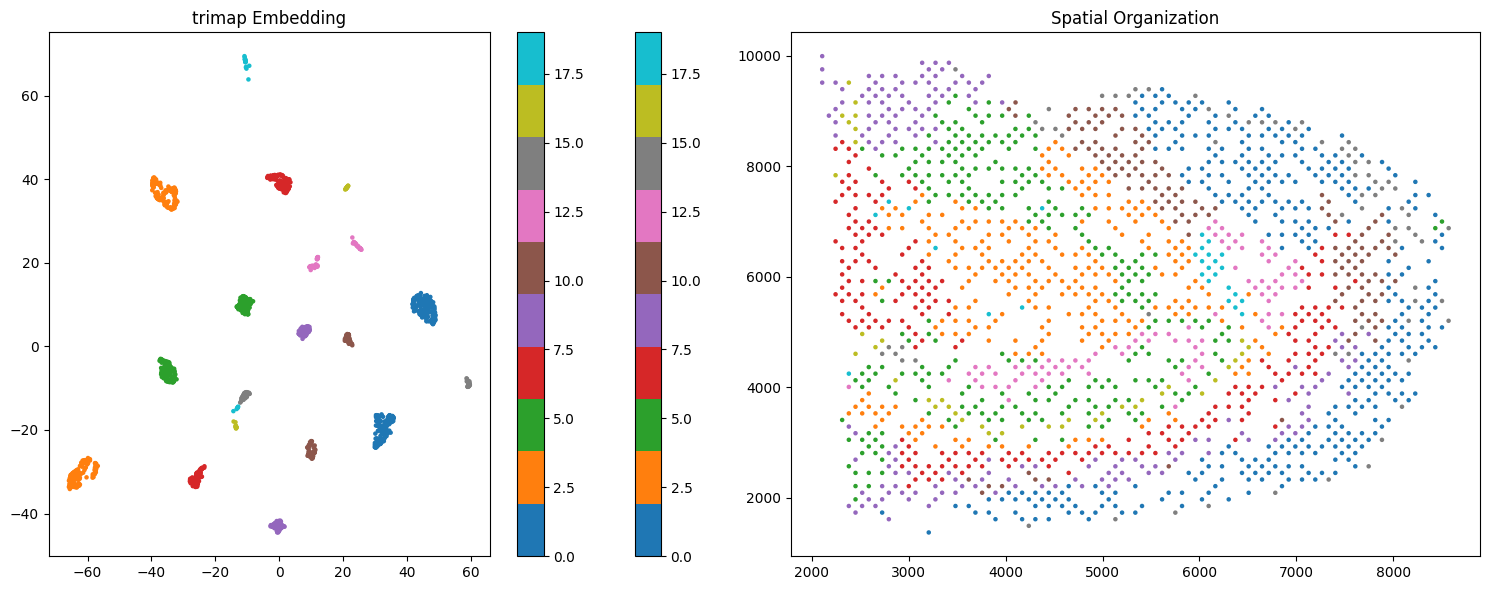

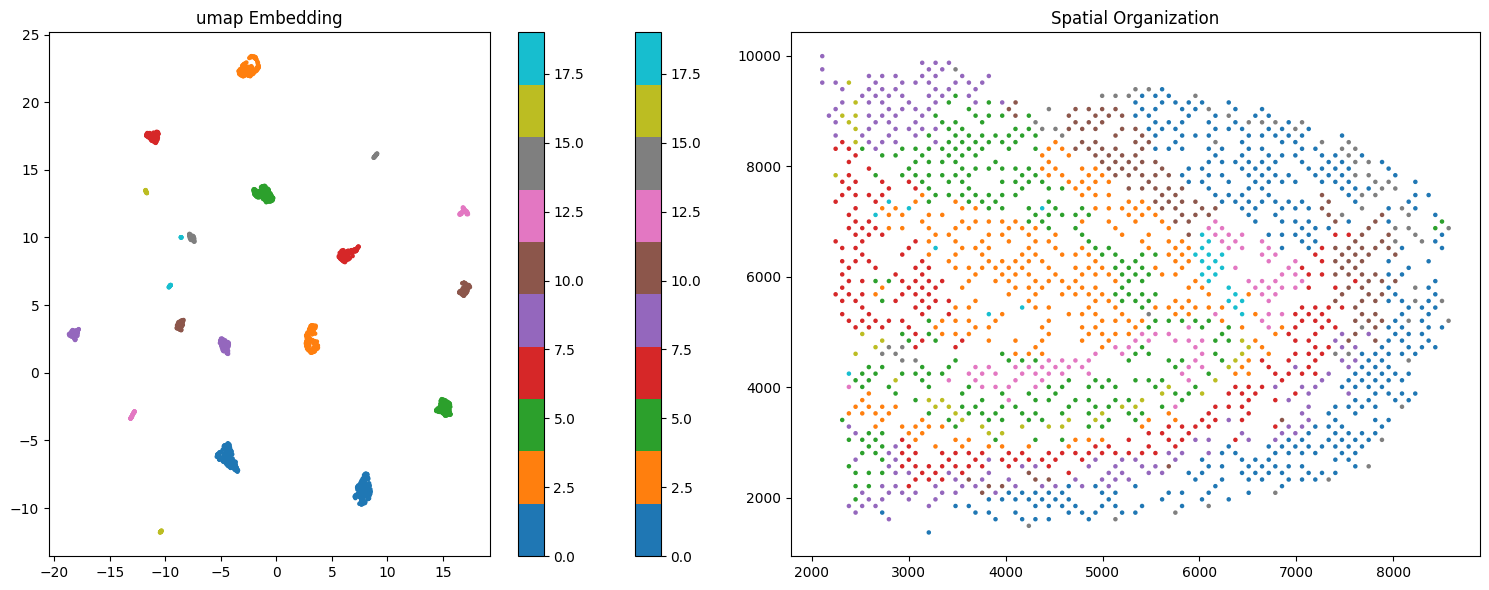

KNN with 3 nearest neighbors
Accuracy: 90.71%

KNN with 5 nearest neighbors
Accuracy: 90.71%

KNN with 10 nearest neighbors
Accuracy: 90.71%



In [17]:
for embedding_algorithm in embeddings_algorithms:
    plot_and_evaluate_embedding(
        train_hidden2.numpy(), 
        train_labels.numpy(), 
        train_spatial_coords,
        test_hidden2.numpy(), 
        test_labels.numpy(), 
        test_spatial_coords,
        embedding_algorithm,
        [3, 5, 10]
    )


The spatial plots show that some regions of the tissue have smooth color changes, meaning gene expression changes gradually, while other areas have sharp color boundaries, showing clear separations between layers. Spots that are close together in space usually have similar gene expression, but there are exceptions, especially at the edges between layers. Overall, these visualizations help us see where tissue regions change, where boundaries are, and how cells might interact based on their location and gene activity.


## Excercise 2

Dataset shape: (2800, 16562)
Available annotations: ['in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster']


/Users/mnozkiewicz/Magisterka/Wizualizacja/venv/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


<Figure size 1200x1000 with 0 Axes>

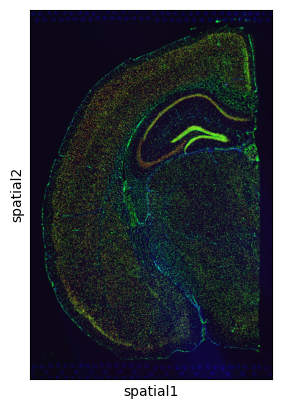

In [18]:
# Load breast cancer dataset
adata_bc = sq.datasets.visium_fluo_adata()
 
# Basic data exploration
print(f"Dataset shape: {adata_bc.shape}")
print(f"Available annotations: {list(adata_bc.obs.columns)}")
 
# Preprocess data
sc.pp.normalize_total(adata_bc, target_sum=1e4)
sc.pp.log1p(adata_bc)
sc.pp.highly_variable_genes(adata_bc, n_top_genes=2000)
adata_bc_hvg = adata_bc[:, adata_bc.var.highly_variable]
sc.pp.scale(adata_bc_hvg)
 
# View tissue structure
plt.figure(figsize=(12, 10))
sc.pl.spatial(adata_bc, img_key="hires", size=1.5)

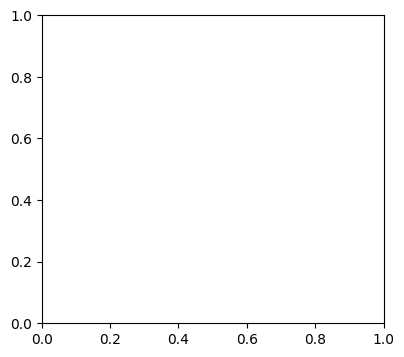

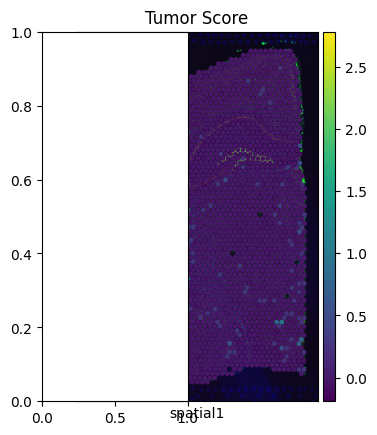

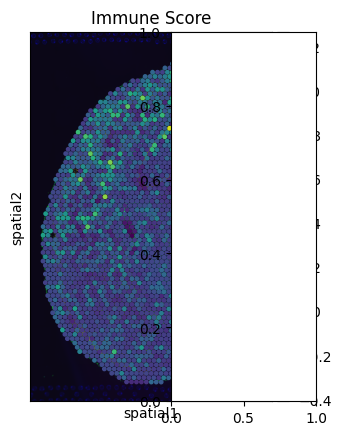

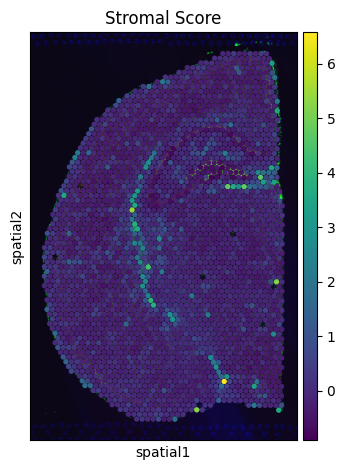

In [19]:
# Define marker genes for different cell types
tumor_markers = ['Epcam', 'Krt17', 'Krt8', 'Krt18']
immune_markers = ['Cd34', 'Cd4', 'Cd84', 'Cd68', 'Cd163']
stromal_markers = ['Col1a1', 'Vim', 'Acta2', 'Fap']
 
# Calculate scores for each cell type
sc.tl.score_genes(adata_bc, tumor_markers, score_name='tumor_score')
sc.tl.score_genes(adata_bc, immune_markers, score_name='immune_score')
sc.tl.score_genes(adata_bc, stromal_markers, score_name='stromal_score')
 
 
# Visualize cell type scores
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
sc.pl.spatial(adata_bc, color='tumor_score', size=1.5, show=False)
plt.title('Tumor Score')
plt.subplot(1, 3, 2)
sc.pl.spatial(adata_bc, color='immune_score', size=1.5, show=False)
plt.title('Immune Score')
plt.subplot(1, 3, 3)
sc.pl.spatial(adata_bc, color='stromal_score', size=1.5, show=False)
plt.title('Stromal Score')
plt.tight_layout()
plt.show()

In [20]:
X_bc = adata_bc_hvg.X.copy()
labels = np.argmax(adata_bc.obs.loc[:, ['tumor_score', 'immune_score', 'stromal_score']].to_numpy(), axis=1)

In [21]:
class AutoEncoderDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

indices = np.arange(len(X_bc))

X_train, X_temp, train_ind, temp_ind = train_test_split(X_bc, indices, test_size=0.4, random_state=42)
X_val, X_test, val_ind, test_ind = train_test_split(X_temp, temp_ind, test_size=0.5, random_state=42)

train_loader = DataLoader(AutoEncoderDataset(X_train), batch_size=64)
val_loader = DataLoader(AutoEncoderDataset(X_val), batch_size=64)
test_loader = DataLoader(AutoEncoderDataset(X_test), batch_size=64)

In [25]:
class AutoEncoder(nn.Module):

    def __init__(self, encoding_dim: int = 64):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(2000, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, encoding_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 2000),
        )
 
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    @torch.no_grad
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

In [26]:
import torch.optim as optim
from copy import deepcopy
from typing import Callable


def evaluate_autoencoder(
        model: AutoEncoder,
        loader: DataLoader,
        loss_fn: Callable
    ) -> float:

    total_loss = 0.0
    number_of_batches = 0
    model = model.eval()

    with torch.no_grad():
        for images in loader:
            outputs = model(images)
            
            batch_loss = loss_fn(outputs, images)
            total_loss += batch_loss.item()

            number_of_batches += 1

    average_loss = total_loss / number_of_batches
    return average_loss
    

def train_autoencoder(
        model: AutoEncoder, 
        train_loader: DataLoader,
        val_loader: DataLoader,
    ) -> AutoEncoder:

    optimizer = optim.AdamW(model.parameters())
    criterion = nn.MSELoss()

    best_model, best_loss = model, float("inf")
    steps_without_improvement = 0
    train_losses, val_losses = [], []

    for epoch in range(20):
        epoch_loss = 0.0
        number_of_batches = 0
        model.train()

        for inputs in train_loader:

            outputs = model(inputs)
            batch_loss = criterion(outputs, inputs)
            batch_loss.backward()

            optimizer.step()
            optimizer.zero_grad()
        
            epoch_loss += batch_loss.item()
            number_of_batches += 1
        
        train_loss = epoch_loss / number_of_batches
        train_losses.append(train_loss)

        val_loss = evaluate_autoencoder(model, val_loader, criterion)
        val_losses.append(val_loss)

        if epoch % 4 == 0:
            print(f"Epoch {epoch}")
            print(f"Train average loss: {train_loss:.3f}, Validation average loss: {val_loss:.3f}")

        if val_loss < best_loss:
            steps_without_improvement = 0
            best_loss = val_loss
            best_model = deepcopy(model)
        else:
            steps_without_improvement += 1
            if steps_without_improvement > 2:
                print("Early stopping")
                print(f"Epoch {epoch}")
                print(f"Train average loss: {train_loss:.3f}, Validation average loss: {val_loss:.3f}")
                break 
    
    plot_training_stats(train_losses, val_losses)
    return best_model

Epoch 0
Train average loss: 0.990, Validation average loss: 0.976
Epoch 4
Train average loss: 0.898, Validation average loss: 0.935
Epoch 8
Train average loss: 0.861, Validation average loss: 0.921
Epoch 12
Train average loss: 0.832, Validation average loss: 0.920
Early stopping
Epoch 15
Train average loss: 0.821, Validation average loss: 0.924


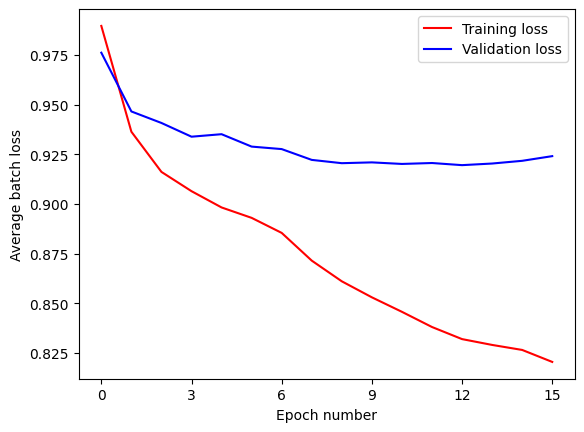

In [27]:
autoencoder = AutoEncoder(encoding_dim=64)
autoencoder = train_autoencoder(autoencoder, train_loader, val_loader)

In [28]:
def retrieve_autoencoder_outputs(model: AutoEncoder, loader: DataLoader) -> torch.Tensor:
    all_hidden_states = []

    for batch in loader:
        batch_hidden_states = model.encode(batch)
        all_hidden_states.append(batch_hidden_states)

    return torch.concat(all_hidden_states)

In [30]:
train_input = X_bc[train_ind]
train_labels = labels[train_ind]
train_spatial_coords = adata_bc.obsm['spatial'][train_ind]

test_input = X_bc[test_ind]
test_labels = labels[test_ind]
test_spatial_coords = adata_bc.obsm['spatial'][test_ind]

train_hidden = retrieve_autoencoder_outputs(autoencoder, train_loader).numpy()
test_hidden = retrieve_autoencoder_outputs(autoencoder, test_loader).numpy()


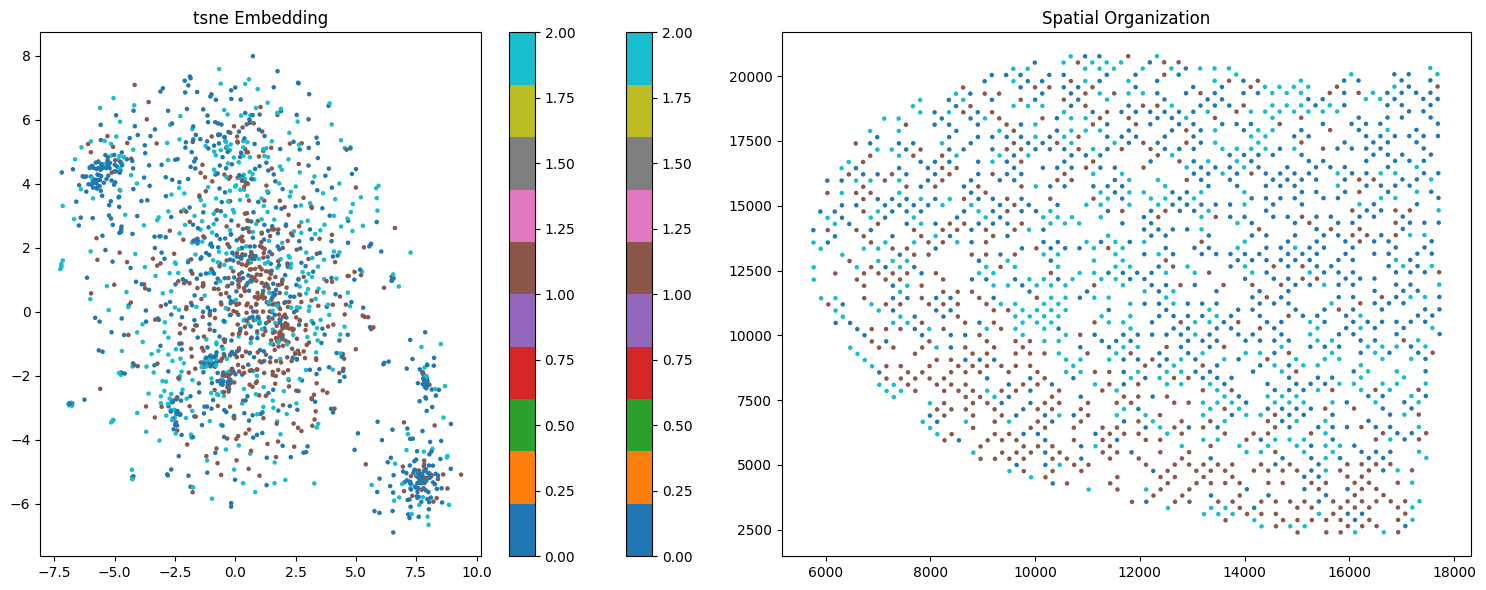

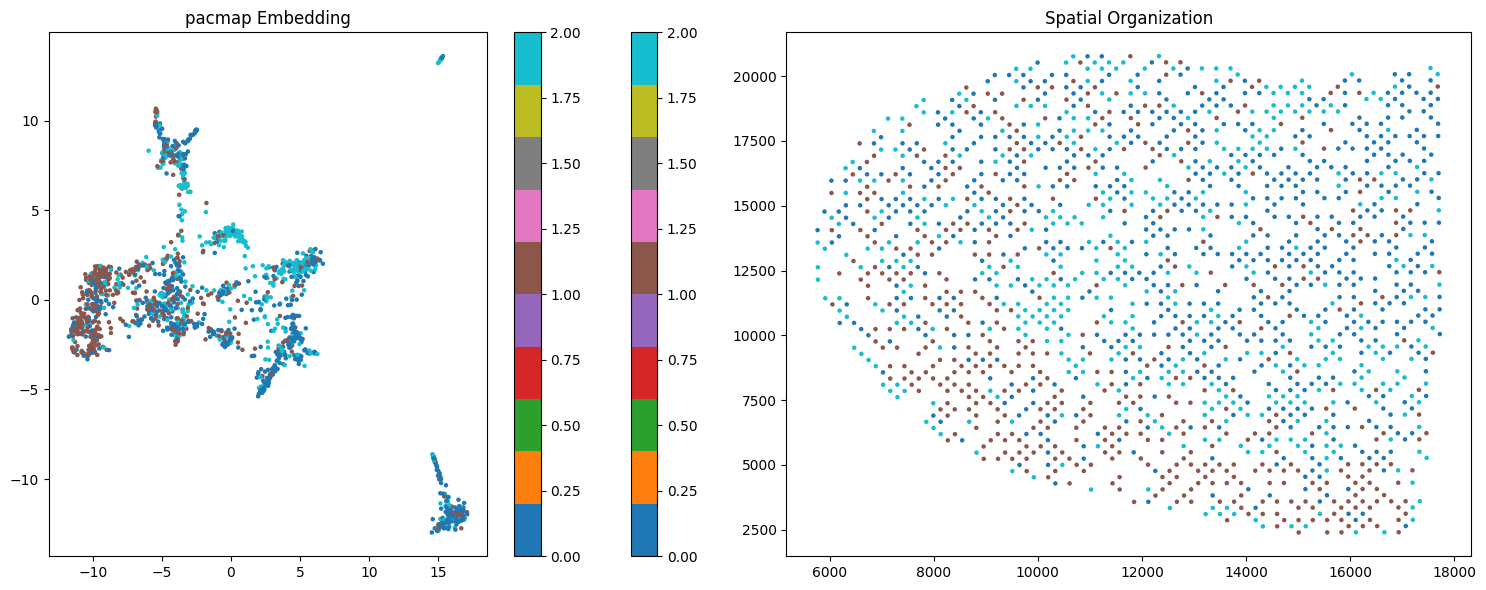

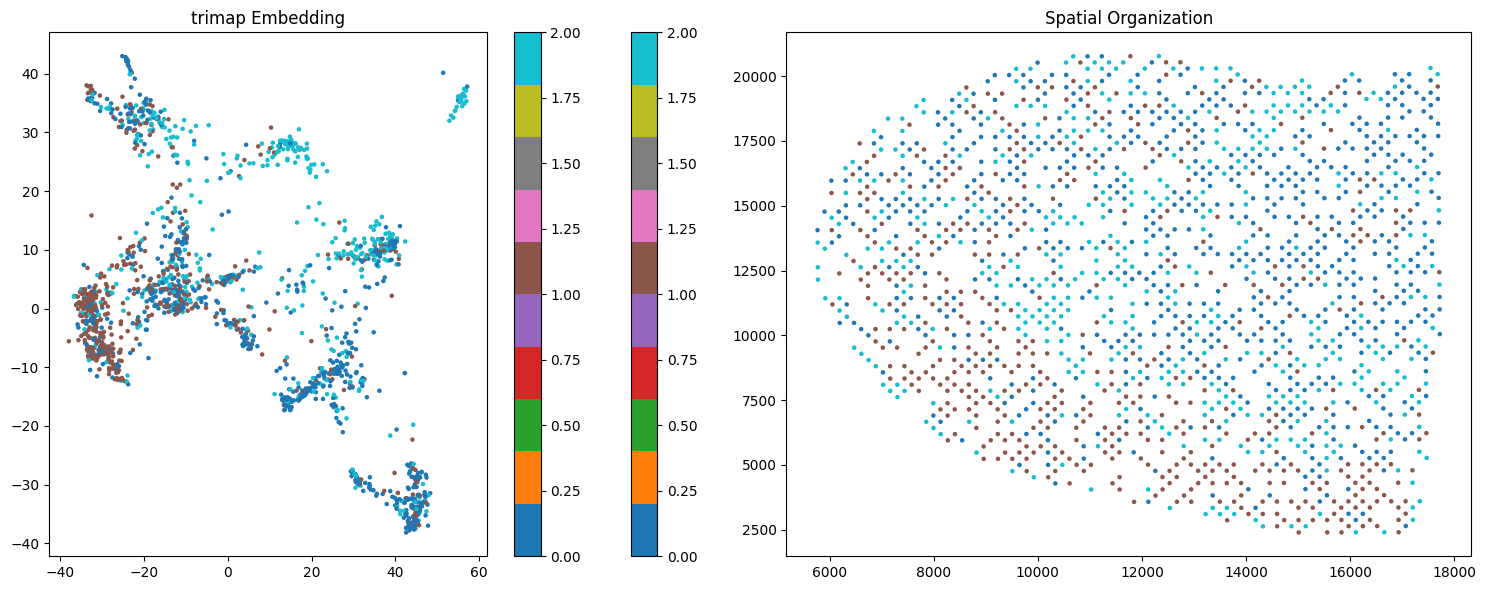

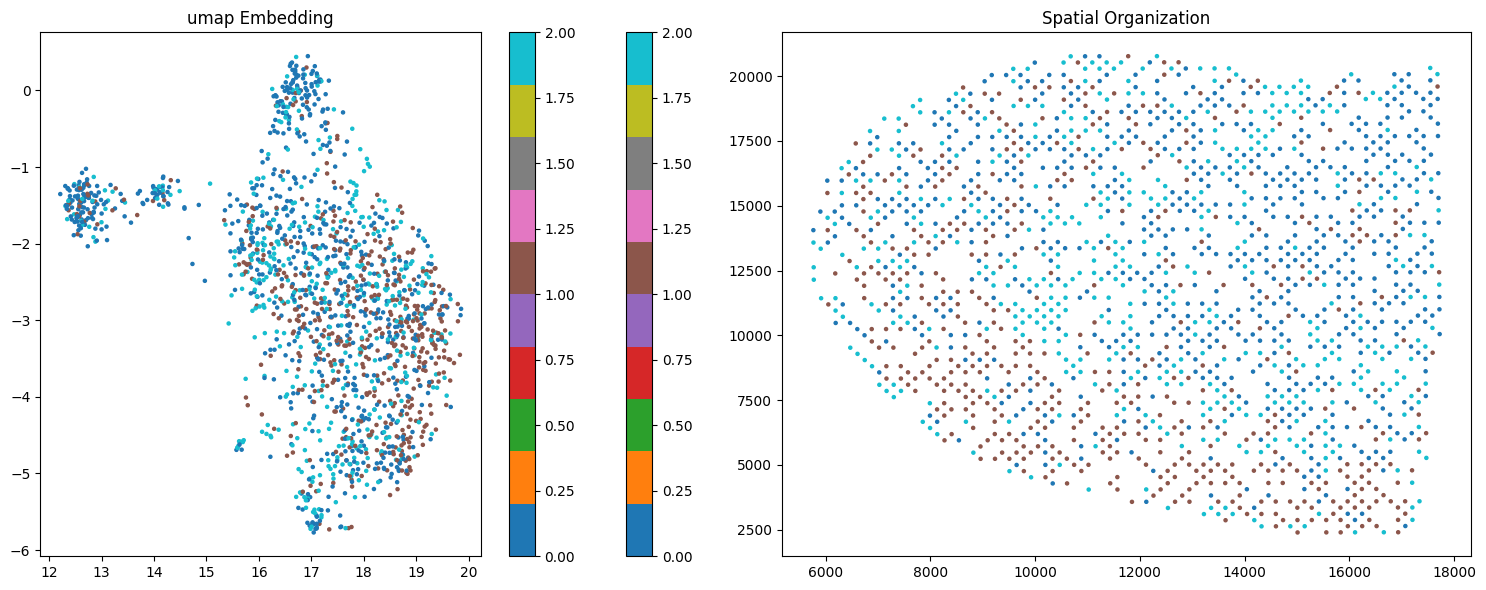

KNN with 3 nearest neighbors
Accuracy: 47.14%

KNN with 5 nearest neighbors
Accuracy: 47.50%

KNN with 10 nearest neighbors
Accuracy: 48.57%



In [31]:
embeddings_algorithms = ["tsne", "pacmap", "trimap", "umap"]

for embedding_algorithm in embeddings_algorithms:
    plot_and_evaluate_embedding(
        train_input, 
        train_labels, 
        train_spatial_coords,
        test_input, 
        test_labels,
        test_spatial_coords,
        embedding_algorithm,
        [3, 5, 10]
    )

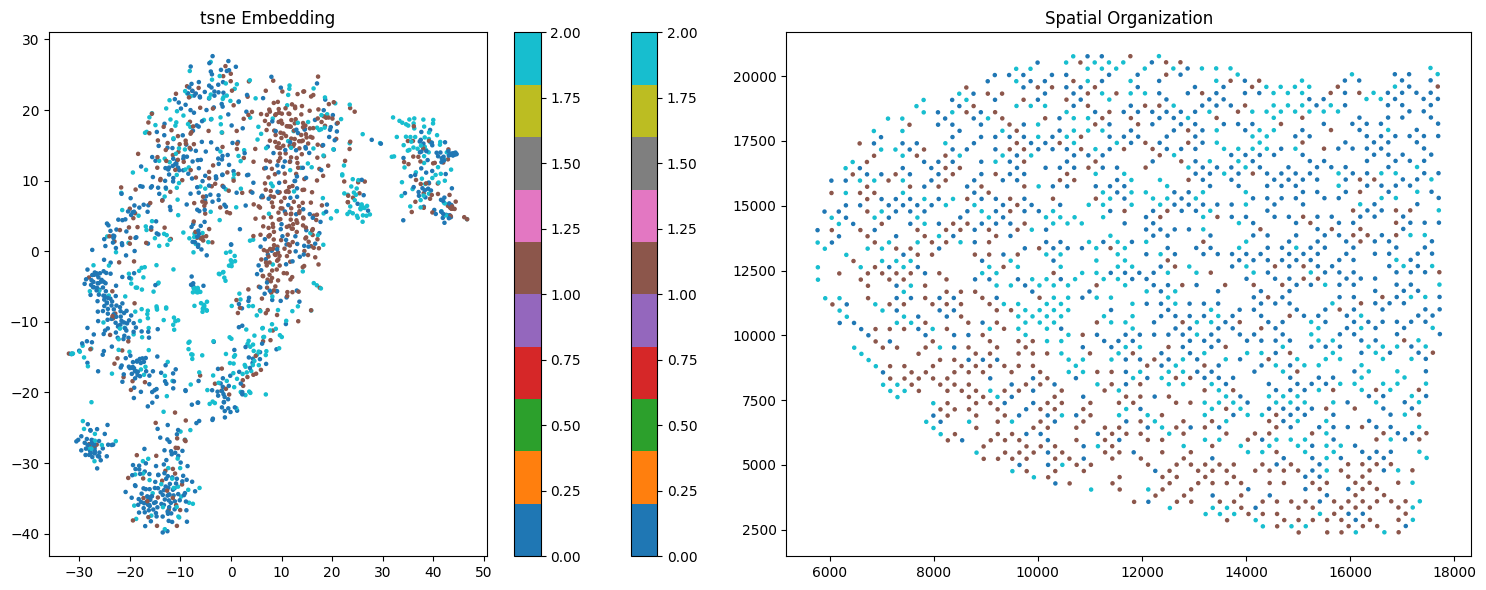

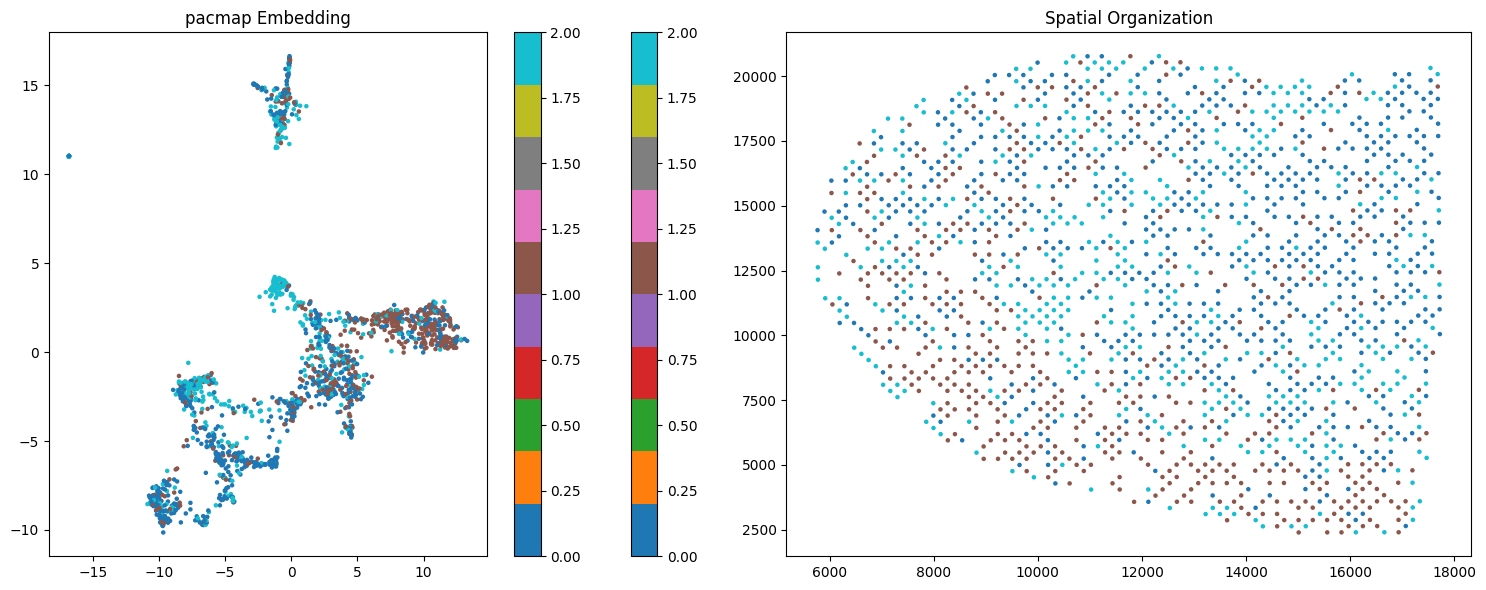

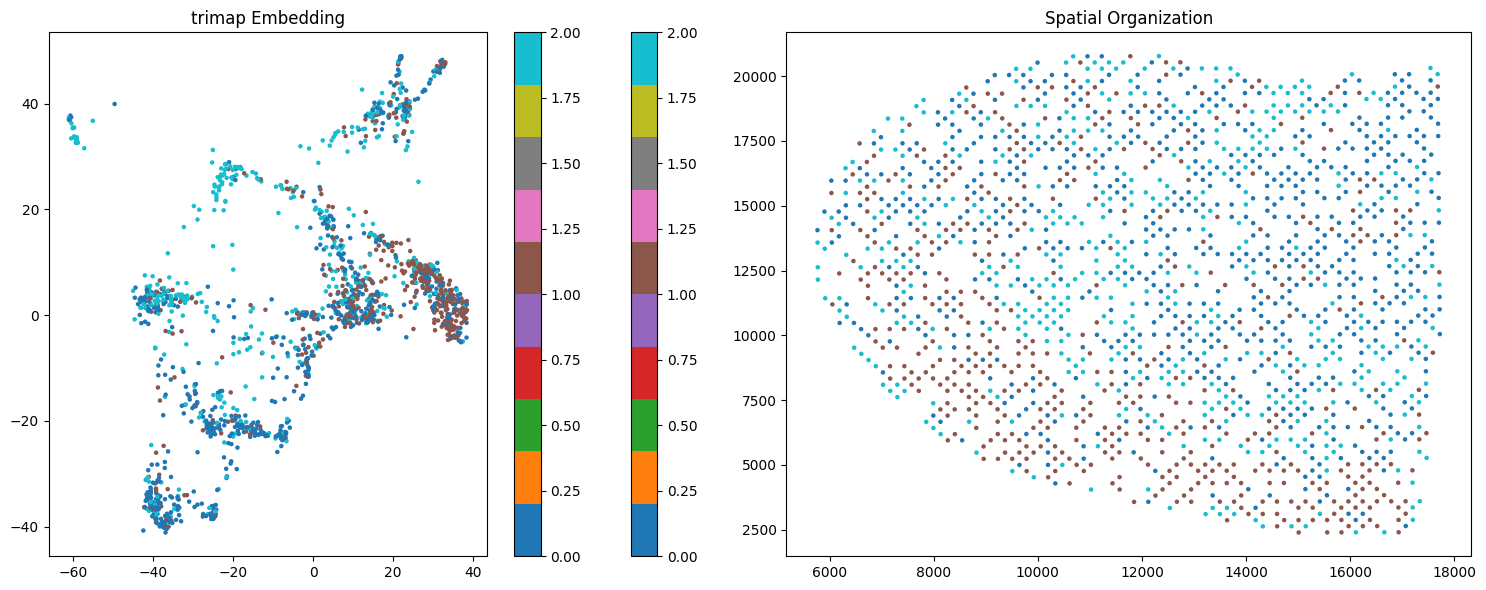

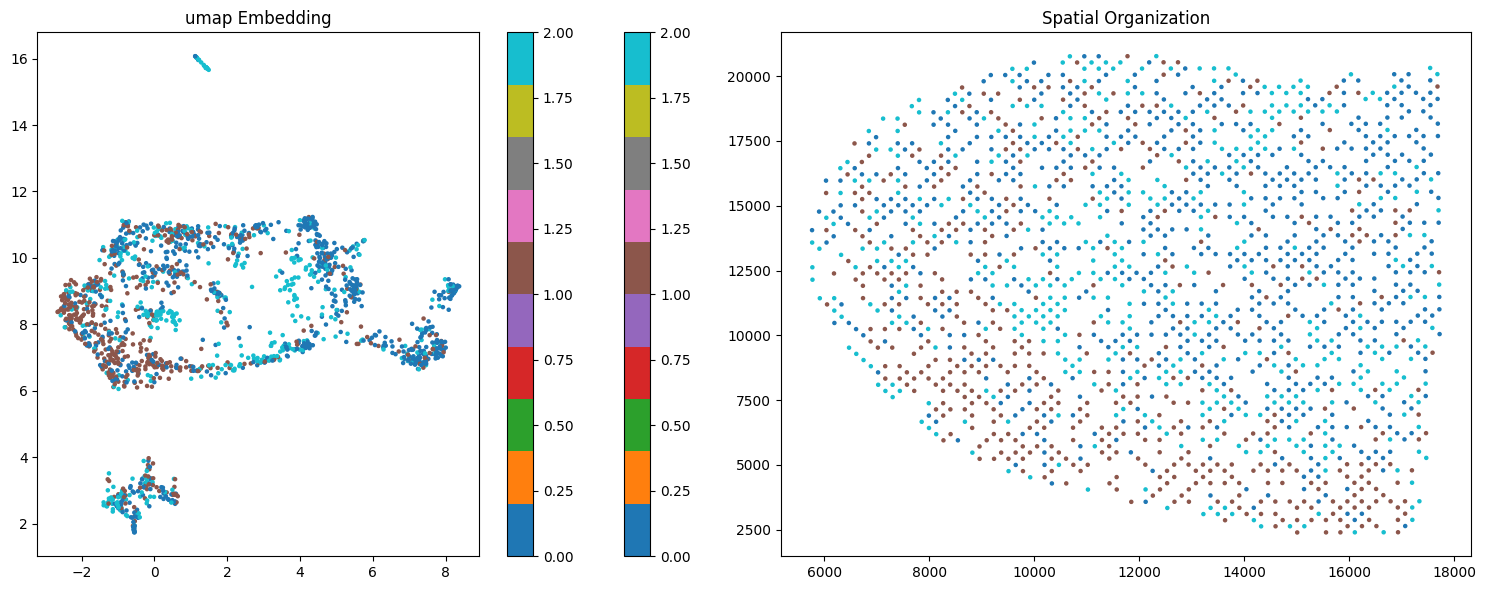

KNN with 3 nearest neighbors
Accuracy: 53.21%

KNN with 5 nearest neighbors
Accuracy: 55.89%

KNN with 10 nearest neighbors
Accuracy: 57.32%



In [32]:
for embedding_algorithm in embeddings_algorithms:
    plot_and_evaluate_embedding(
        train_hidden, 
        train_labels, 
        train_spatial_coords,
        test_hidden, 
        test_labels,
        test_spatial_coords,
        embedding_algorithm,
        [3, 5, 10]
    )

<Figure size 1000x800 with 0 Axes>

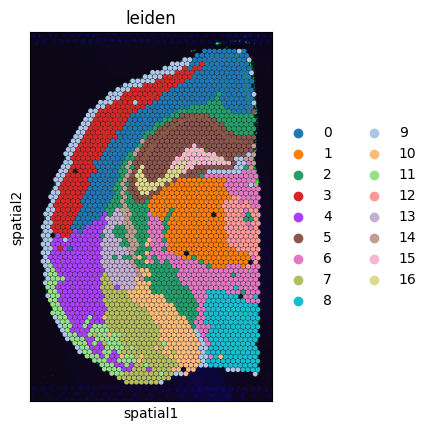

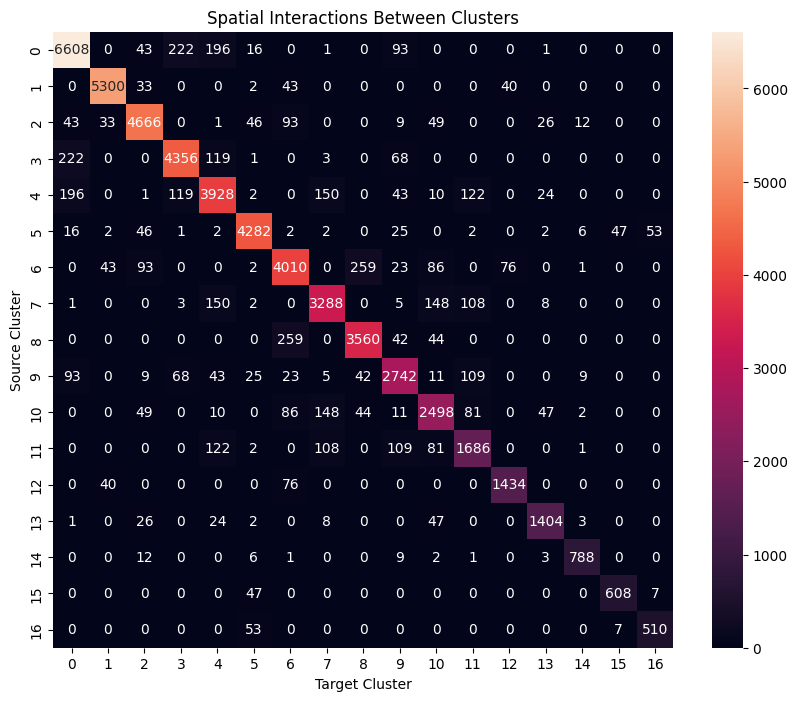

In [33]:
import seaborn as sns

# Compute neighborhood graph to analyze cell-cell interactions
sc.pp.neighbors(adata_bc, use_rep='X_pca')
 
# Find clusters/regions
sc.tl.leiden(adata_bc, resolution=0.8)
 
# Visualize clusters in spatial context
plt.figure(figsize=(10, 8))
sc.pl.spatial(adata_bc, color='leiden', size=1.5)
 
# Compute interaction scores between regions
def compute_interactions(adata, cluster_key='leiden'):
    # Count neighbors of different clusters for each spot
    clusters = adata.obs[cluster_key].cat.categories
    n_clusters = len(clusters)
 
    # Get the indices of nearest neighbors from the connectivities matrix
    connectivity = adata.obsp['connectivities']
 
    # Initialize interaction matrix
    interaction_matrix = np.zeros((n_clusters, n_clusters))
 
    # For each spot, count interactions with spots of different clusters
    for i in range(adata.n_obs):
        # Get the cluster of the current spot
        current_cluster = adata.obs[cluster_key][i]
        current_idx = np.where(clusters == current_cluster)[0][0]
 
        # Get indices of neighbors
        neighbors = connectivity[i].nonzero()[1]
 
        # Count neighbors by cluster
        for neighbor in neighbors:
            neighbor_cluster = adata.obs[cluster_key][neighbor]
            neighbor_idx = np.where(clusters == neighbor_cluster)[0][0]
            interaction_matrix[current_idx, neighbor_idx] += 1
 
    return interaction_matrix, clusters
 
# Compute and visualize interactions
interaction_matrix, cluster_names = compute_interactions(adata_bc)
 
# Visualize interaction matrix
plt.figure(figsize=(10, 8))
sns.heatmap(interaction_matrix, annot=True, fmt='.0f',
            xticklabels=cluster_names, yticklabels=cluster_names)
plt.title('Spatial Interactions Between Clusters')
plt.xlabel('Target Cluster')
plt.ylabel('Source Cluster')
plt.show()

By analyzing marker gene scores, I observed distinct spatial patterns for tumor, immune, and stromal cells within the tissue. The neural network models reveal hidden structure in the data, making the separation between cell types clearer in the visualizations. Examining spatial interactions between clusters highlighted regions where tumor and immune cells are in close proximity, suggesting possible areas of interaction.
